<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/hr-analytics/hr-analytics/HR_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving [HR Analytics Job Change](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists) using Neural Network and Google Colab

In [1]:
#hide
!pip install -Uqq fastbook kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 39.1 MB/s 
     |████████████████████████████████| 186 kB 25.9 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 56 kB 3.3 MB/s 
     |████████████████████████████████| 51 kB 243 kB/s 
Mounted at /content/gdrive


Insert kaggle.json before proceed to the next step

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

In [4]:
!rm -r ~/hr-analytics
!mkdir ~/hr-analytics

rm: cannot remove '/root/hr-analytics': No such file or directory


In [6]:
#Download dataset
api.dataset_download_cli(dataset='arashnic/hr-analytics-job-change-of-data-scientists',
                         path='hr-analytics',
                         unzip=True,
                         force=True)

100%|██████████| 295k/295k [00:00<00:00, 23.7MB/s]

In [7]:
train_ds = pd.read_csv('hr-analytics/aug_train.csv', low_memory=False)
test_ds = pd.read_csv('hr-analytics/aug_test.csv')

In [8]:
train_ds.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [9]:
dep_var = 'target'

## Baseline

In [10]:
train_ds[dep_var].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

What is the probability if I return false in every training data ? This data will be used as baseline

In [11]:
14381 / (14381 +  4777)

0.7506524689424784

This means 75% of accuracy

## Using Neural Network

In [12]:
cont,cat = cont_cat_split(train_ds, max_card=2000, dep_var=dep_var)
cont, cat

(['enrollee_id', 'city_development_index'],
 ['city',
  'gender',
  'relevent_experience',
  'enrolled_university',
  'education_level',
  'major_discipline',
  'experience',
  'company_size',
  'company_type',
  'last_new_job',
  'training_hours'])

In [13]:
procs = [Categorify, FillMissing, Normalize]
tabular_data = TabularPandas(train_ds, 
                      procs, 
                      cat, 
                      cont,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train_ds)), 
                      y_names=dep_var,
                      y_block = CategoryBlock )

In [74]:
dls = tabular_data.dataloaders(128)
dls.show_batch()

,city,relevent_experience,enrolled_university,major_discipline,experience,company_size,company_type,last_new_job,training_hours,enrollee_id,city_development_index,target
0,city_103,Has relevent experience,no_enrollment,STEM,>20,500-999,Pvt Ltd,4,18,7379.000222,0.920,0.0
1,city_67,No relevent experience,Full time course,STEM,11,#na#,#na#,>4,78,19160.000061,0.855,0.0
2,city_45,No relevent experience,no_enrollment,STEM,9,50-99,Pvt Ltd,3,51,5672.999574,0.890,0.0
3,city_75,Has relevent experience,no_enrollment,STEM,14,#na#,#na#,1,158,31241.000084,0.939,0.0
4,city_40,No relevent experience,Full time course,#na#,3,#na#,Pvt Ltd,never,22,483.999746,0.776,0.0
5,city_90,Has relevent experience,no_enrollment,STEM,2,#na#,#na#,1,112,14384.000068,0.698,1.0
6,city_103,Has relevent experience,no_enrollment,STEM,>20,#na#,#na#,1,95,29802.000124,0.920,0.0
7,city_149,Has relevent experience,#na#,#na#,3,#na#,#na#,never,99,2721.999579,0.689,1.0
8,city_103,Has relevent experience,no_enrollment,STEM,>20,#na#,#na#,1,112,29382.000496,0.920,1.0
9,city_160,Has relevent experience,no_enrollment,STEM,7,1000-4999,Pvt Ltd,1,102,6146.000275,0.920,0.0


SuggestedLRs(valley=0.0014454397605732083)

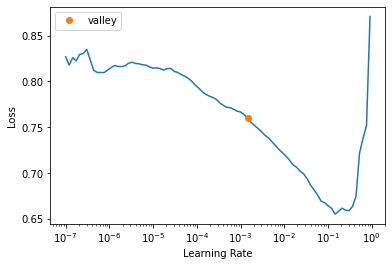

In [88]:
learn = tabular_learner(dls,
                        metrics=[accuracy, RocAucBinary()],
                        loss_func = CrossEntropyLossFlat())
learn.lr_find()

In [89]:
learn.fit_one_cycle(2, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.479022,0.447616,0.788306,0.798466,00:02
1,0.443191,0.443239,0.793526,0.800616,00:02


SuggestedLRs(valley=0.009120108559727669)

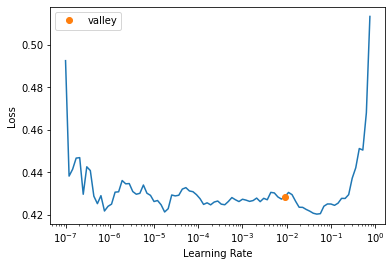

In [91]:
learn.lr_find()

In [92]:
learn.fit_one_cycle(5, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.418421,0.443395,0.794832,0.800203,00:02
1,0.413256,0.445174,0.790916,0.799496,00:02
2,0.415362,0.445678,0.792743,0.799139,00:02
3,0.412259,0.445553,0.793004,0.799231,00:02
4,0.411777,0.445689,0.791177,0.799135,00:02


## Filtering Features Using Random Forest

In [23]:
def rf(xs, y, n_estimators=40, max_samples=10_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [27]:
m = rf(xs, y);

In [28]:
xs,y = tabular_data.train.xs,tabular_data.train.y
valid_xs,valid_y = tabular_data.valid.xs,tabular_data.valid.y

In [29]:
roc_auc_score(y.to_numpy(), m.predict(xs)), roc_auc_score(valid_y.to_numpy(), m.predict(valid_xs))

(0.9410569633041788, 0.7839462248757387)

In [30]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

Plot important features

In [31]:
fi = rf_feat_importance(m, xs)
fi[:13]

,cols,imp
12,city_development_index,0.287118
11,enrollee_id,0.134784
10,training_hours,0.112291
7,company_size,0.105453
6,experience,0.072505
0,city,0.062925
8,company_type,0.058707
9,last_new_job,0.041917
5,major_discipline,0.033990
4,education_level,0.031605


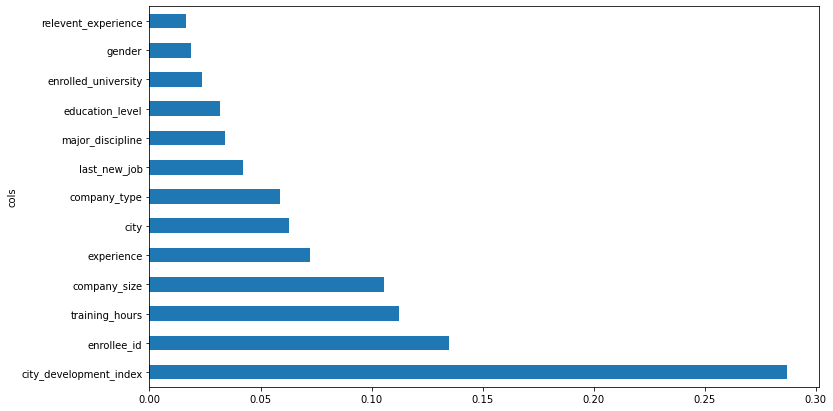

In [32]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

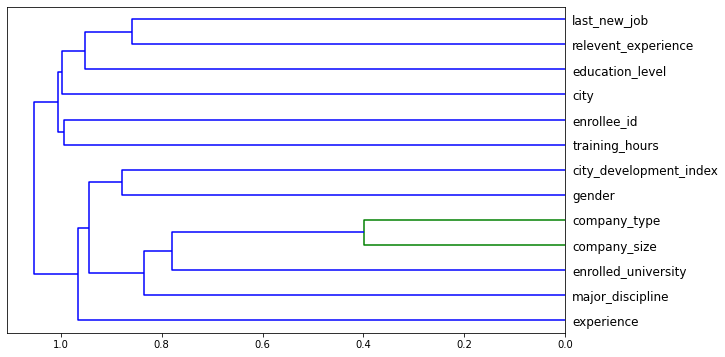

In [33]:
cluster_columns(xs)

In [34]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=5000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Set baseline Out Of Bag score

In [35]:
get_oob(xs)

0.2620753623847427

In [36]:
{c:get_oob(xs.drop(c, axis=1)) for c in (
    'relevent_experience', 'gender', 'enrolled_university','education_level',
    'major_discipline', 'last_new_job',
    'company_type','experience', 'city')}

{'city': 0.26336506905819834,
 'company_type': 0.25813172558272846,
 'education_level': 0.2624978035421546,
 'enrolled_university': 0.26199426581208896,
 'experience': 0.260118292581078,
 'gender': 0.2623700388020266,
 'last_new_job': 0.25963773146959346,
 'major_discipline': 0.25465131337940505,
 'relevent_experience': 0.259457029858018}

In [119]:
to_drop = [ 'gender']
get_oob(xs.drop(to_drop, axis=1))

0.2619238148801344

Compared to baseline, dropping gender does not change OOB much. So it is okay to delete the feature from learning

In [120]:
xs_final = xs.drop(to_drop, axis=1)
valid_xs_final = valid_xs.drop(to_drop, axis=1)

In [121]:
m = rf(xs_final, y)
roc_auc_score(y.to_numpy(), m.predict(xs_final)), roc_auc_score(valid_y.to_numpy(), m.predict(valid_xs_final))

(0.942312146456595, 0.7784306151354354)

In [122]:
cont_nn,cat_nn = cont_cat_split(train_ds, max_card=9000, dep_var=dep_var)

cat_nn.remove('gender')

## Test Again

In [124]:
tabular_data = TabularPandas(train_ds, 
                      procs, 
                      cat_nn, 
                      cont_nn,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train_ds)), 
                      y_names=dep_var,
                      y_block = CategoryBlock )

dls = tabular_data.dataloaders(128)
learn = tabular_learner(dls,
                        metrics=[accuracy, RocAucBinary()],
                        loss_func = CrossEntropyLossFlat())

SuggestedLRs(valley=0.0014454397605732083)

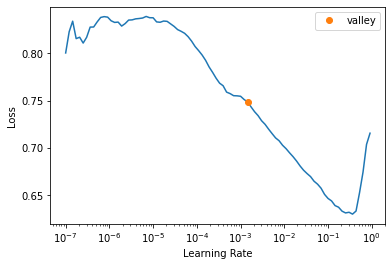

In [125]:
learn.lr_find()

In [126]:
learn.fit_one_cycle(2, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.477594,0.448016,0.791699,0.802954,00:02
1,0.436217,0.438265,0.797442,0.803229,00:02


SuggestedLRs(valley=0.00013182566908653826)

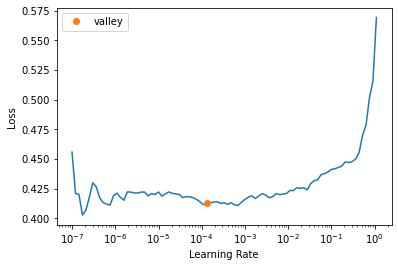

In [127]:
learn.lr_find()

In [128]:
learn.fit_one_cycle(5, 2e-4, wd=0.01)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.416673,0.437241,0.797703,0.803614,00:02
1,0.412257,0.438378,0.796659,0.803809,00:02
2,0.410535,0.440976,0.798747,0.803049,00:02
3,0.408168,0.441877,0.797703,0.802025,00:02
4,0.403692,0.441888,0.797964,0.802132,00:02


The ROC AUC score does not change much

## Prediction

In [129]:
test_dl = learn.dls.test_dl(test_ds)
predictions = learn.get_preds(dl=test_dl)

In [130]:
predictions, predictions[0][:,1]

((tensor([[0.8598, 0.1402],
          [0.8769, 0.1231],
          [0.3217, 0.6783],
          ...,
          [0.8349, 0.1651],
          [0.9214, 0.0786],
          [0.9146, 0.0854]]), None),
 tensor([0.1402, 0.1231, 0.6783,  ..., 0.1651, 0.0786, 0.0854]))

In [131]:
result = pd.DataFrame({'enrollee_id': test_ds['enrollee_id'], 'target': predictions[0][:,1]})
result.head()

,enrollee_id,target
0,32403,0.140214
1,9858,0.123055
2,31806,0.678261
3,27385,0.095382
4,27724,0.053271


In [132]:
result.to_csv('result.csv')